[482.50890892256797, 328.0255541764342, 16.539033532446222, 0.3, 10.932432330337182, 10.767163198666008, 50.639678876199476, 4.512356080460492]


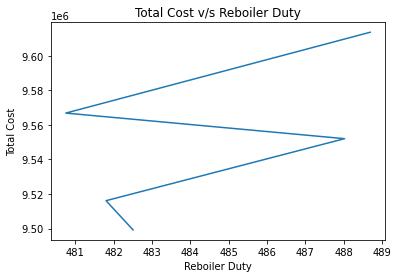

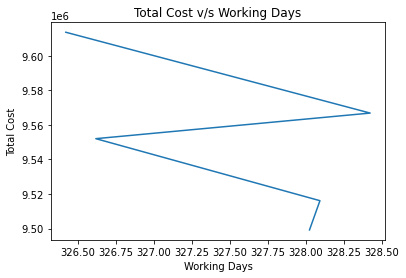

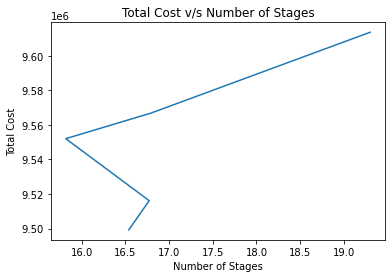

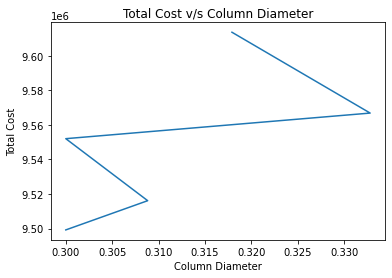

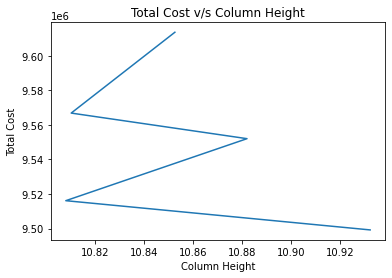

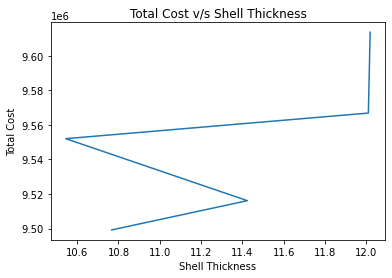

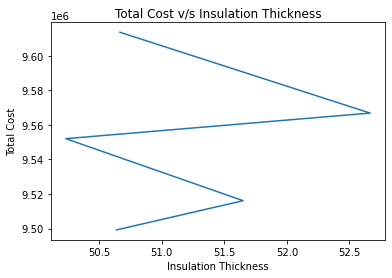

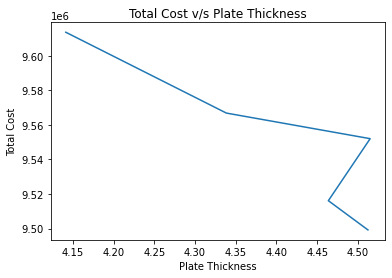

Optimal Stages: 16.539033532446222
Optimal Cost: 9499232.209647104


In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import random as random
import math

# problem definition
def totalCost(individual):
    # constant                 unit
    costSteam = 1.47          # Rs/kg
    latentheatSteam = 2257    # kJ/kg
    densitySteel = 7833.4     # kg/m^3
    densityAsbestos = 270     # kg/m^3
    costSteel = 50            # Rs/kg
    costInsulation = 2670     # Rs/kg
    
    #===================================================Genotype and Phenotype==========================#
    # | reboilerDuty | workingDays | stages | columnDia | columnHt | shellTh | insulationTh | plateTh | #
    #                                                                                                   #
    # | 470 to 530 | 325 to 335 | 13 to 25 | 0.3 to 2.5 | 9 to 15 | 8 to 14 | 45 to 55 | 3 to 6 |       #
    #===================================================================================================#
    
    # independent variable        unit
    reboilerDuty = individual[0] # kW
    workingDays = individual[1]  # days/year
    stages = individual[2]       # ------
    columnDia = individual[3]    # m
    columnHt = individual[4]     # m
    shellTh = individual[5]      # mm
    insulationTh = individual[6] # mm
    plateTh = individual[7]      # mm
    
    # dependent varable                                  unit
    headTh = shellTh                                     # mm 
    holeDia = plateTh                                    # mm
    towerCrossSecArea = np.pi*(columnDia**2)/4           # m^2
    innerColDia = columnDia                              # m
    outerColDia = columnDia + 2*0.001*shellTh            # m
    insulatedColDia = outerColDia + 2*0.001*insulationTh # m
    
    # Total amount of Steel we require in kg
    M = ((0.37 * innerColDia + towerCrossSecArea) * 0.001 * plateTh * stages + np.pi * (innerColDia**2) * 0.001 * headTh + \
           0.6 * np.pi * ((outerColDia**2) - (innerColDia**2)) * columnHt) * (1.1 * densitySteel)
    
    # Total amount of Asbestos we require in kg
    A = np.pi * ((insulatedColDia**2) - (outerColDia**2)) * columnHt * densityAsbestos / 4
    
    return (1000 * reboilerDuty * costSteam * workingDays * 24 * 3600) / (1000 * latentheatSteam) + (M * costSteel) + (A * costInsulation)

    
def roulettewheelSelection(p):
    r = random.random()
    cumsum = np.cumsum(p)
    y = (cumsum<r)
    x= [i for i in y if i==True]
    return len(x)-1
   
def crossover(parent1, parent2, varMin, varMax):
    # Range of the random generator. A random value will be sampled between -gamma and 1+gamma.
    # This sampled value will be used to perform a convex combination between parent1 and parent2
    gamma = 0.1 
    nVar = len(parent1)
    alpha = np.random.uniform(-gamma, 1 + gamma, nVar)
    child1 = alpha * np.array(parent1) + (1 - alpha) * np.array(parent2)
    child2 = alpha * np.array(parent2) + (1 - alpha) * np.array(parent1)
    
    child1 = [varMin[i] if j<varMin[i] else j for i, j in zip(range(nVar), child1)]
    child1 = [varMax[i] if j>varMax[i] else j for i, j in zip(range(nVar), child1)]

    child2 = [varMin[i] if j<varMin[i] else j for i, j in zip(range(nVar), child2)]
    child2 = [varMax[i] if j>varMax[i] else j for i, j in zip(range(nVar), child2)]
  
    return [child1, child2]

def mutate(child, varMin, varMax):

    nVar = len(child)
    mu_rate = 0.3
    nmutaion = int(mu_rate * nVar)
    index = np.random.randint(0 , nVar - 1, size = (1, nmutaion))[0].tolist()
    child = np.array(child)
    varMin = np.array(varMin)
    varMax = np.array(varMax)
    mutant = child
    normalrandom = child[index] + 0.1 * (varMax[index]-varMin[index]) * np.random.randn(1, len(index))[0]
    mutant[index] = normalrandom

    mutant = [varMin[i] if j<varMin[i] else j for i, j in zip(range(nVar), mutant)]
    mutant = [varMax[i] if j>varMax[i] else j for i, j in zip(range(nVar), mutant)]
    
    return mutant

varMin = [470, 325, 13, 0.3, 9, 8, 45, 3]
varMax = [530, 335, 25, 1.5, 15, 14, 55, 6]
nVar = 8               # number of decision varaibles
varSize = (1,nVar)

# GA parameters
maxGeneration= 350      # max generation number
nPop = 50                # number population

cP = 0.95            # crossover percentage
nCh = 2*round(cP*nPop/2) # number of offsprings = number of parents

beta = lambda reboilerDuty : 0.00000001*(reboilerDuty - 496)**2

# initialization
# class Individual:
#     position = []
#     cost = []
# population = [Individual() for individual in range(nPop)]

population = [[] for individual in range(nPop)]
populationCost = [[] for individual in range(nPop)]

for individual in range(nPop):
    for var in range(nVar):
        population[individual].append(round(random.uniform(varMin[var],varMax[var]),4))
    populationCost[individual] = totalCost(population[individual])

# sort population
sorted_index = np.argsort(populationCost)
populationCost = np.sort(populationCost).tolist()
population = [population[individual] for individual in sorted_index[0:nPop]]

# store best solution
bestSol = populationCost[0]
best_reboilerDuty = []
best_workingDays = []
best_stages = []
best_columnDia = [] 
best_columnHt = []
best_shellTh = []
best_insulationTh = []
best_plateTh = []
best_costMemory = []

# generation loop
for generation in range(maxGeneration):
                                 
    # elitism
    nextGeneration = population[0:nPop-nCh]
    nextGenerationCost = populationCost[0:nPop-nCh]
    # crossover 2 parent => 2 child
    for reProduction in range(int(nCh/2)):
            
        # calculate selection probablity
        p = [(1 - 1 / (1 + math.exp(-beta(population[individual][0]) * populationCost[individual]))) for individual in range(nPop)]
        sump = sum(p)
        p = [elem/sump for elem in p]
         
        # select first parent
        index1 = roulettewheelSelection(p)
        parent1 = population[index1]
        
        # select second parent
        index2 = roulettewheelSelection(p)
        parent2 = population[index2]

        children = crossover(parent1, parent2, varMin, varMax)
        
        # mutation of child 1
        mutProb = random.random()
        if(mutProb <= 0.05):
            children[0] = mutate(children[0], varMin, varMax)
        
        # mutation of child 2
        mutProb = random.random()
        if(mutProb <= 0.05):
            children[1] = mutate(children[1], varMin, varMax)
        
        nextGeneration.extend(children)
        nextGenerationCost.extend([totalCost(child) for child in children])

    # sort next generation
    sorted_index = np.argsort(nextGenerationCost)
    nextGenerationCost = np.sort(nextGenerationCost).tolist()
    nextGeneration = [nextGeneration[individual] for individual in sorted_index[0:nPop]]

    # Replace the current population by the nextGeneration
    population = nextGeneration 
    populationCost = nextGenerationCost
    
    best_reboilerDuty.append(population[0][0])
    best_workingDays.append(population[0][1])
    best_stages.append(population[0][2])
    best_columnDia.append(population[0][3])
    best_columnHt.append(population[0][4])
    best_shellTh.append(population[0][5])
    best_insulationTh.append(population[0][6])
    best_plateTh.append(population[0][7])
    best_costMemory.append(populationCost[0])

print(population[0])
plt.plot(best_reboilerDuty, best_costMemory)
plt.title('Total Cost v/s Reboiler Duty')
plt.xlabel('Reboiler Duty')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_workingDays, best_costMemory)
plt.title('Total Cost v/s Working Days')
plt.xlabel('Working Days')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_stages, best_costMemory)
plt.title('Total Cost v/s Number of Stages')
plt.xlabel('Number of Stages')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_columnDia, best_costMemory)
plt.title('Total Cost v/s Column Diameter')
plt.xlabel('Column Diameter')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_columnHt, best_costMemory)
plt.title('Total Cost v/s Column Height')
plt.xlabel('Column Height')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_shellTh, best_costMemory)
plt.title('Total Cost v/s Shell Thickness')
plt.xlabel('Shell Thickness')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_insulationTh, best_costMemory)
plt.title('Total Cost v/s Insulation Thickness')
plt.xlabel('Insulation Thickness')
plt.ylabel('Total Cost')
plt.show()

plt.plot(best_plateTh, best_costMemory)
plt.title('Total Cost v/s Plate Thickness')
plt.xlabel('Plate Thickness')
plt.ylabel('Total Cost')
plt.show()

print('Optimal Stages: ' + str(best_stages[maxGeneration - 1]))
print('Optimal Cost: ' + str(best_costMemory[maxGeneration - 1]))

